In [3]:
print("importing packages...")
import numpy as np
import bayesflow as bf
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
print("successfully imported packages.")

importing packages...


successfully imported packages.


c:\Users\ellio\OneDrive\Desktop\upload_to_Zotero\Python\Python_environments\test_env\Lib\site-packages\bayesflow\trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [4]:
# set random seed
RNG = np.random.default_rng(2025)

In [ ]:
# DEFINING PARAMETERS FOR THE MODEL
n          = 100  ##############     # Sample size of each dataset
p          = 25  ##############     # Number of covariates

# true betas
beta0 = 2*((np.array(list(range(1,p+1)), dtype = np.float32) % 5) - 2)
beta0

rho   = 0.0 ##########
SNR = 0.8 ############

# CREATING COVARIATES FOR THE MODEL
# importing the X from R
X = np.loadtxt("../shared_data/p_" + str(p) + "/X_p" + str(p) + ".csv", delimiter=",", dtype=str)[1:,1:]
X = np.array(X, dtype = np.float64)

# # generating the X
# X = RNG.normal(size = (n,p))
# for j in range(1,p):
#     X[:,j] = rho*(X[:,j-1]) + np.sqrt(1-rho**2)*X[:,j]

# creating X1 and H
X1 = np.concatenate((np.ones((n,1)), X), axis = 1)
H  = np.dot(np.linalg.pinv(np.dot(X1.transpose(),X1)), X1.transpose())
###################################

sigma0 = np.sqrt(np.var(np.dot(X,beta0))/SNR - np.var(np.dot(X,beta0)))

print("This is the signal-to-noise ratio:")
print(np.var(np.dot(X,beta0))/(np.var(np.dot(X,beta0)) + sigma0**2))

log_sigma0 = np.log(sigma0)
alpha0     = 1
a          = 0.5
b          = 0.05
tau        = .0005
SD         = 10
true_parameters = np.concatenate(([log_sigma0], [alpha0], beta0))
nparams = true_parameters.shape[0]

This is the signal-to-noise ratio:
0.8


In [1791]:
# DEFINING THE PRIOR FOR THE MODEL
def prior_fun(D=p): # this shouldn't have any arguments, so any arguments should have default values
    
    # generate sigma
    sigma = 1/np.sqrt(stats.gamma.ppf(RNG.uniform(low=0.001,high=0.999,size=1), a, scale=1/b))
    
    # calculate log_sigma
    log_sigma = np.log(sigma)

    # generate lambda
    lambda_param = np.sqrt(1/RNG.beta(a=0.5, b=0.5, size = 1) - 1)

    # # generating sd -- sparsity
    # generating_sd = (lambda_param**2)*(tau**2)

    # generating sd -- wide normal
    generating_sd = SD

    # generate alpha
    alpha = RNG.normal(loc=0,scale = generating_sd, size = 1)
    # alpha = [1]

    # generate betas
    betas = RNG.normal(loc=0,scale = generating_sd, size = p)
    # betas = np.ones((p,))

    # combine all parameters of interest (CHANGE THIS)
    total_params = np.concatenate((log_sigma, alpha, betas))
    return total_params # the output should be a numpy array

prior = bf.simulation.Prior(prior_fun=prior_fun)

example_prior_draws = prior(batch_size = 1)
print(example_prior_draws["prior_draws"].shape)
print(example_prior_draws["prior_draws"])

(1, 7)
[[ -2.15187008 -11.29192775 -24.41866646   7.65391403  -7.59709345
    2.66996195   7.01780852]]


In [1792]:
# DEFINING THE LIKELIHOOD FOR THE MODEL

# Defining the likelihood in terms of the Y's
def likelihood_fun_Ys(params, n_obs=n): 
    tr_Ys = RNG.normal(loc=params[1] + np.dot(X,params[2:(p+2)]),scale=np.exp(params[0]),size = n_obs)
    tr_Ys = np.expand_dims(tr_Ys, 1) # need to do this for the summary network
    return tr_Ys # should return a numpy array
simulator_Ys = bf.simulation.Simulator(simulator_fun=likelihood_fun_Ys)
example_Y_draws = simulator_Ys(params = example_prior_draws["prior_draws"])
print(example_Y_draws["sim_data"].shape)




# Defining the likelihood in terms of the LSE's
def likelihood_fun_LSEs(params, n_obs=n): 
    tr_Ys = RNG.normal(loc=params[1] + np.dot(X,params[2:(p+2)]),scale=np.exp(params[0]),size = n_obs)
    b = np.dot(H,tr_Ys)
    sig = np.std(tr_Ys - np.dot(X1, b))
    log_sig = np.log(sig)
    total_stats = np.concatenate(([log_sig], b))
    stats_to_return = np.expand_dims(total_stats, 1) # need to do this for the summary network
    return stats_to_return # should return a numpy array
simulator_LSEs = bf.simulation.Simulator(simulator_fun=likelihood_fun_LSEs)
example_LSE_draws = simulator_LSEs(params = example_prior_draws["prior_draws"])
print(example_LSE_draws["sim_data"].shape)
print(example_LSE_draws["sim_data"])
# Tying the prior together with the likelihood in a Generative model (one for each likelihood)
model_Ys = bf.simulation.GenerativeModel(prior=prior, simulator=simulator_Ys)
model_LSEs = bf.simulation.GenerativeModel(prior=prior, simulator=simulator_LSEs)

# The generative model is callable and returns a dictionary... the main keys are "prior_draws" and "sim_data"
# prior_draws is a numpy array of: N x parameter dimension = N x nparams
# sim_data is a numpy array of:  N x sample size x parameter dimension = N x n x nparams

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 7)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 100, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 7)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 7, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


(1, 100, 1)
(1, 7, 1)
[[[ -2.07339562]
  [-11.29570999]
  [-24.42687985]
  [  7.66123122]
  [ -7.60376615]
  [  2.66853265]
  [  7.03211284]]]


In [1793]:
# DRAW FROM THE GENERATIVE MODEL TO FORM OUR DATASET OF SIMULATION DRAWS

# arguments
N          = 10000 # number of datasets used in VaNBayes
N_val      = round(N*.2)  # validation
N_tr       = N - N_val # training

# generating the datasets
generated_data_Ys = model_Ys(batch_size=N_tr)
generated_data_LSEs = model_LSEs(batch_size=N_tr)

# Defining the Normalizing Flow

In [1797]:
# arguments
num_layers = 2 # I mostly used 6... typical choices are 6-10
nstats = nparams # heuristically should not be lower than the number of parameters in the model
mydesign = "affine" # choices: "affine" (harder problems, more general), "spline" (works well for low-dimensional problems)
permute = "fixed" # choices: "fixed" (highly recommended, but permutes them), None (no permutation), "learnable"
model_to_use = model_LSEs # model_Ys, model_LSEs
generated_data_to_use = generated_data_LSEs # generated_data_Ys, generated_data_LSEs
simulator_to_use = simulator_LSEs # simulator_Ys, simulator_LSEs 

# DEFINING THE SUMMARY NETWORK -- part 1 of the Normalizing Flow
summary_net = bf.networks.DeepSet(summary_dim=nstats)    
# Inputs to the summary network must be: N x n x (dimension of Y)
# Outputs of the summary network are: N x nstats


# DEFINING THE INFERENCE NETWORK -- part 2 of the Normalizing Flow
inference_net = bf.networks.InvertibleNetwork(
    num_params=nparams,
    num_coupling_layers=num_layers,
    coupling_design=mydesign,
    permutation=permute
)
# Inputs to the inference network must be: N x nstats
# Outputs of the inference network are: N x nparams

# COMBINING THESE INTO OUR BAYESFLOW NORMALIZING FLOW
# Note: Since we are using this to estimate the posterior, we use the "AmortizedPosterior" class
# Here we have the option to include our summary_net or not 
amortizer = bf.amortizers.AmortizedPosterior(inference_net = inference_net)# , summary_net=summary_net)

# Defining the Configurator

In [1798]:
# Configurators return dictionaries of 3 keys: 
# parameters - the posteriors we will estimate
# summary_conditions - what will be passed into the summary network
# direct_conditions - what will be passed directly into the inference network, skipping the summary network entirely

# Important: 
# If we are NOT using a summary network, the data must be passed directly to the inference network, so...
# 1. The sim_data must be put from summary_conditions to direct_conditions
# 2. We must change the dimension of sim_data from N x n x (dimension of Y) to N x n to match the inference network

# CONFIGURATOR WHEN NO SUMMARY NETWORK IS PROVIDED
def no_summary_net(simulation_outputs):
    prior_draws = simulation_outputs["prior_draws"]
    configured_outputs = {
        # "summary_conditions": None,
        "direct_conditions":simulation_outputs["sim_data"][:,:,0].astype(np.float32),
        "parameters": simulation_outputs["prior_draws"].astype(np.float32), # the [:,p:] is for picking out the specific covariates
    }
    return configured_outputs

# CONFIGURATOR WHEN A SUMMARY NETWORK IS PROVIDED
def vanilla_configurator(simulation_outputs):
    prior_draws = simulation_outputs["prior_draws"]
    configured_outputs = {
        "summary_conditions": simulation_outputs["sim_data"].astype(np.float32),
        "direct_conditions":None,
        "parameters": simulation_outputs["prior_draws"].astype(np.float32),
    }
    return configured_outputs

# Trainer: Combines Normalizing Flow with Generative Model + Configurator

In [1799]:
# arguments
my_saving_path = None 
type_of_training = "offline"
num_epochs     = 20
iter_per_epoch = 1000
my_LR = 0.0005

# DEFINING THE TRAINER -- either with or without the summary network
if amortizer.summary_net == None:
    print("not using a summary network")
    trainer = bf.trainers.Trainer(amortizer=amortizer, 
                                  generative_model=model_to_use, 
                                  configurator=no_summary_net, 
                                  default_lr=my_LR, 
                                  checkpoint_path=my_saving_path) 
else: 
    print("using a summary network")
    trainer = bf.trainers.Trainer(amortizer=amortizer, 
                                  generative_model=model_to_use, 
                                  configurator=vanilla_configurator, 
                                  default_lr=my_LR, 
                                  checkpoint_path=my_saving_path) 

### ACTUALLY TRAINING -- either online or offline
if type_of_training == "offline":
    print("starting the offline training (may take awhile)...")
    history = trainer.train_offline(simulations_dict=generated_data_to_use,epochs=num_epochs, batch_size=100, validation_sims=N_val)
    print("offline training finished.")
else: 
    print("starting the online training (may take awhile)...")
    history = trainer.train_online(epochs=num_epochs, iterations_per_epoch=iter_per_epoch, batch_size=32, validation_sims=N_val)
    print("online training finished.")

INFO:root:Performing a consistency check with provided components...


not using a summary network


INFO:root:Done.


starting the offline training (may take awhile)...


INFO:root:Generated 2000 simulations for validation.
Training epoch 1: 100%|██████████| 80/80 [00:07<00:00, 11.12it/s, Epoch: 1, Batch: 80,Loss: 13.096,W.Decay: 0.121,Avg.Loss: 34.847,Avg.W.Decay: 0.120,LR: 4.97E-04] 
INFO:root:Validation, Epoch: 1, Loss: 11.027
Training epoch 2: 100%|██████████| 80/80 [00:00<00:00, 152.52it/s, Epoch: 2, Batch: 80,Loss: 9.814,W.Decay: 0.122,Avg.Loss: 10.891,Avg.W.Decay: 0.122,LR: 4.88E-04] 
INFO:root:Validation, Epoch: 2, Loss: 8.499
Training epoch 3: 100%|██████████| 80/80 [00:00<00:00, 156.67it/s, Epoch: 3, Batch: 80,Loss: 8.813,W.Decay: 0.123,Avg.Loss: 9.744,Avg.W.Decay: 0.123,LR: 4.73E-04]
INFO:root:Validation, Epoch: 3, Loss: 7.897
Training epoch 4: 100%|██████████| 80/80 [00:00<00:00, 157.49it/s, Epoch: 4, Batch: 80,Loss: 8.105,W.Decay: 0.123,Avg.Loss: 9.151,Avg.W.Decay: 0.123,LR: 4.53E-04] 
INFO:root:Validation, Epoch: 4, Loss: 7.273
Training epoch 5: 100%|██████████| 80/80 [00:00<00:00, 156.19it/s, Epoch: 5, Batch: 80,Loss: 9.077,W.Decay: 0.124

offline training finished.


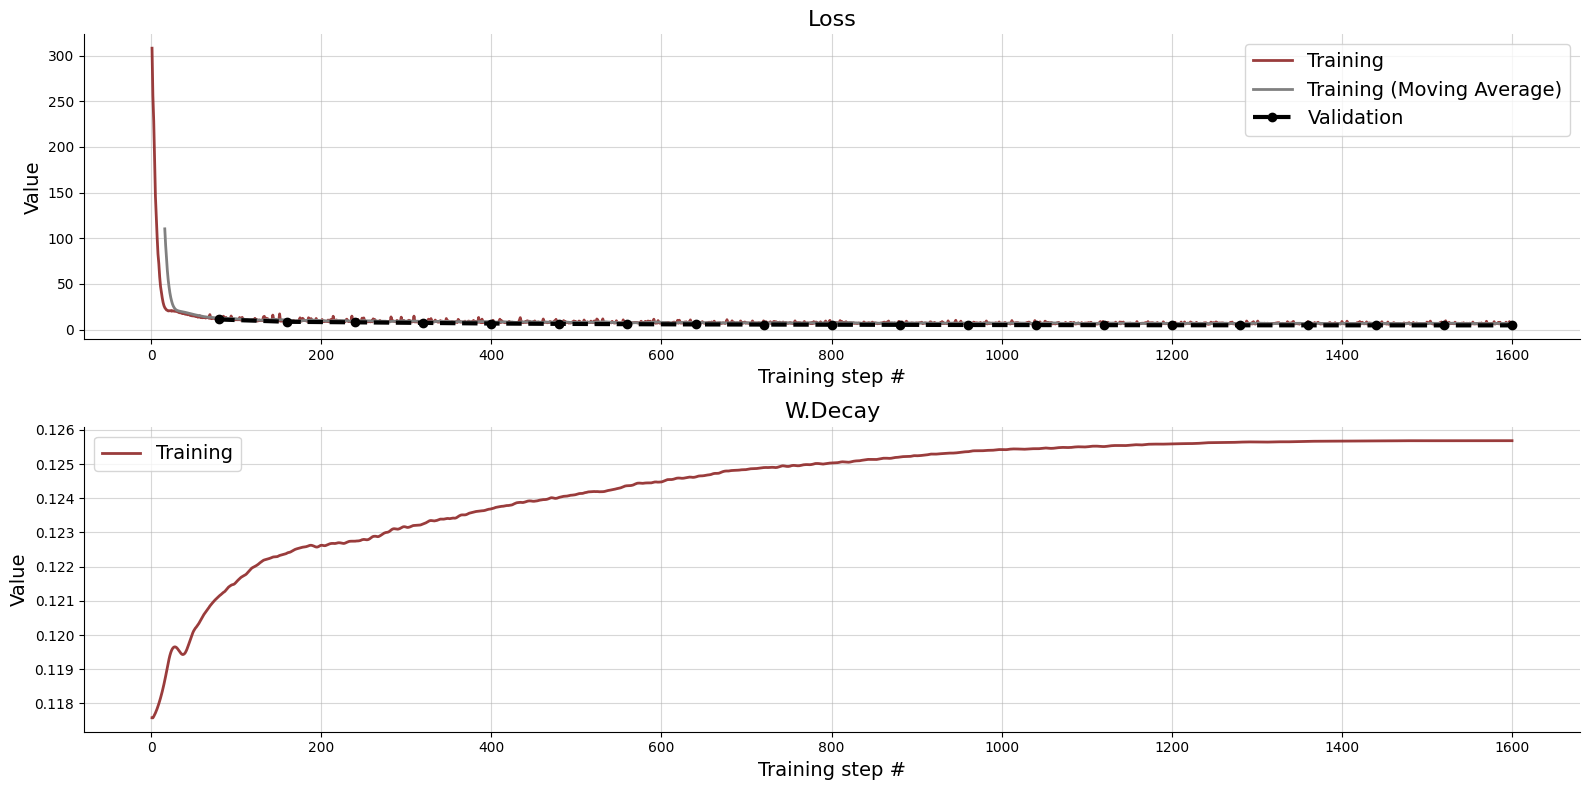

In [1800]:
# The trajectory of the loss function over the fitting time
f = bf.diagnostics.plot_losses(history["train_losses"], history["val_losses"], moving_average=True)
plt.savefig('./diagnostic_plots/p_' + str(p) + '/loss_trajectory.png')

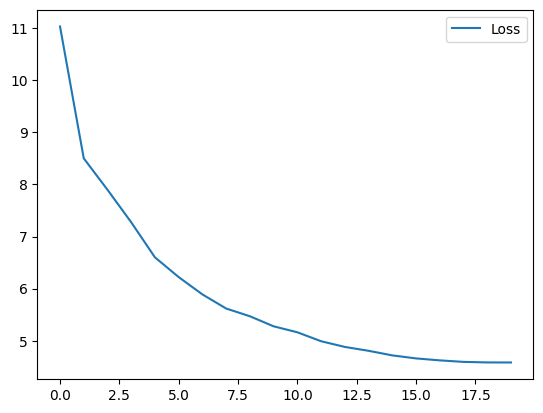

In [1801]:
# the trajectory of the validation loss
sns.lineplot(history["val_losses"])
plt.savefig('./diagnostic_plots/p_' + str(p) + '/val_loss_trajectory.png')

# Diagnostics

In [1802]:
# Generate validation set
number_of_prior_and_sim_draws = 500 # can make this 500 if too slow
normalizing_flow_outputs = trainer.configurator(model_to_use(batch_size=number_of_prior_and_sim_draws))
latent_space_draws, _ = amortizer(normalizing_flow_outputs) # get the corresponding z-score to the normalizing flow output
posterior_draws = amortizer.sample(normalizing_flow_outputs, n_samples=1000) # draw n_samples from the posterior FOR EACH generated dataset (prior and sim draws)

In [1803]:
# # Latent Space Inspection
# # Should be similar to normal distributions
# f = bf.diagnostics.plot_latent_space_2d(latent_space_draws)
# plt.savefig('./diagnostic_plots/p_' + str(p) + '/latent_space_plot.png')


INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 0.                    Confidence intervals might be unreliable!


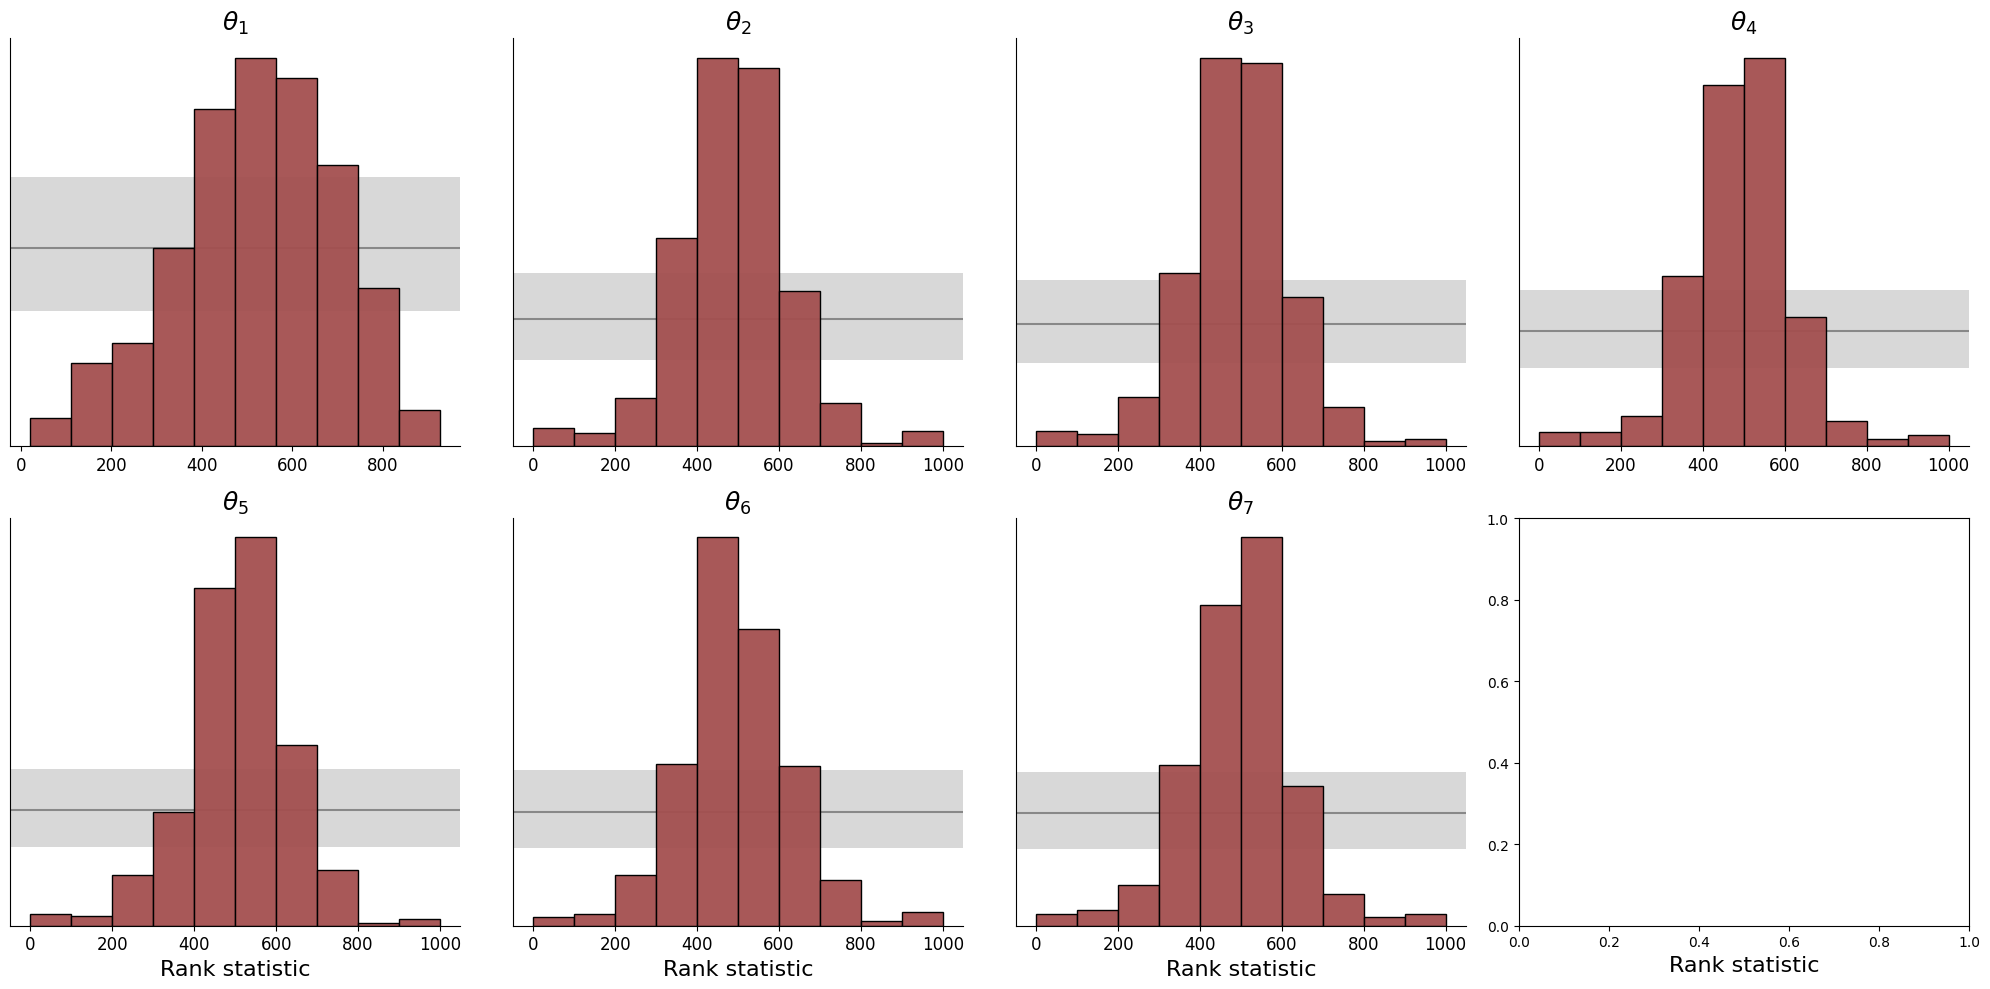

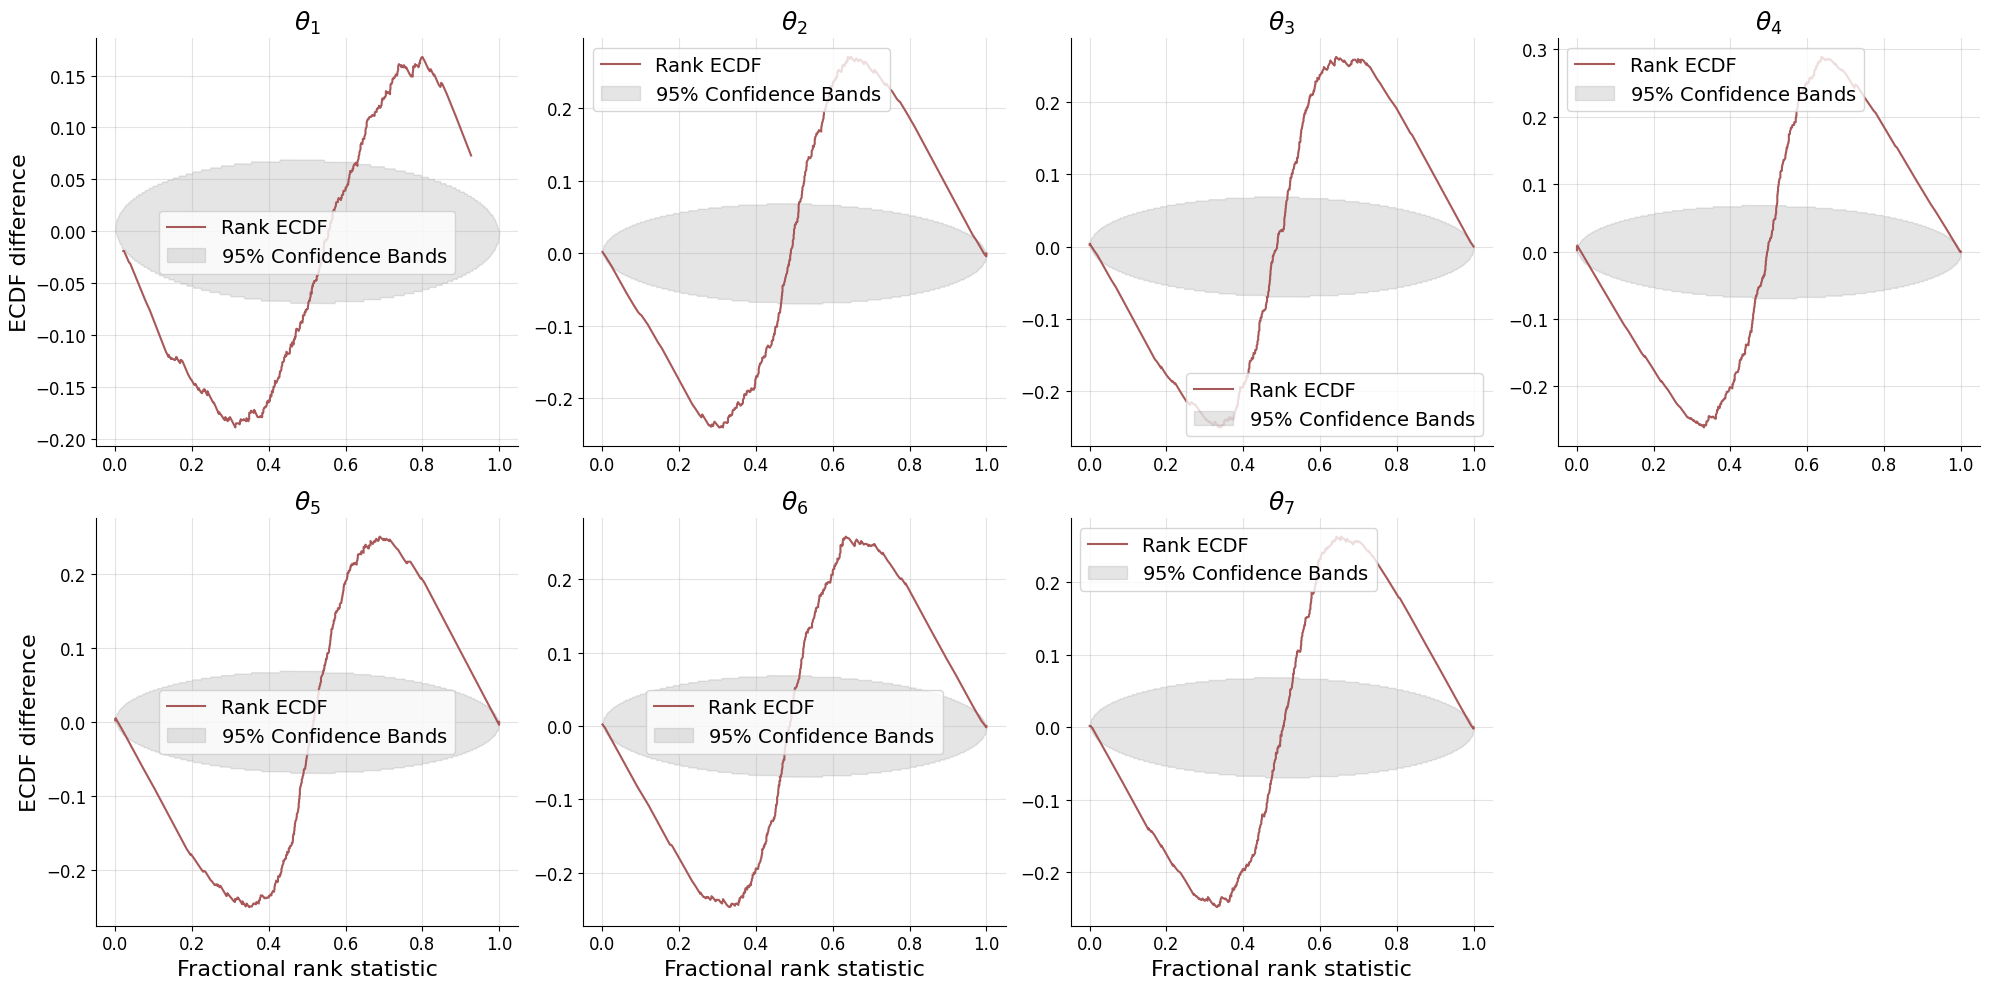

In [1804]:
# Perform Simulation-Based Calibration: should be within gray area
f = bf.diagnostics.plot_sbc_histograms(posterior_draws, normalizing_flow_outputs["parameters"], num_bins=10)
plt.savefig('./diagnostic_plots/p_' + str(p) + '/plot_sbc_histograms.png')
f = bf.diagnostics.plot_sbc_ecdf(posterior_draws, normalizing_flow_outputs["parameters"], difference=True)
plt.savefig('./diagnostic_plots/p_' + str(p) + '/plot_sbc_ecdf.png')


finished diagnostics.


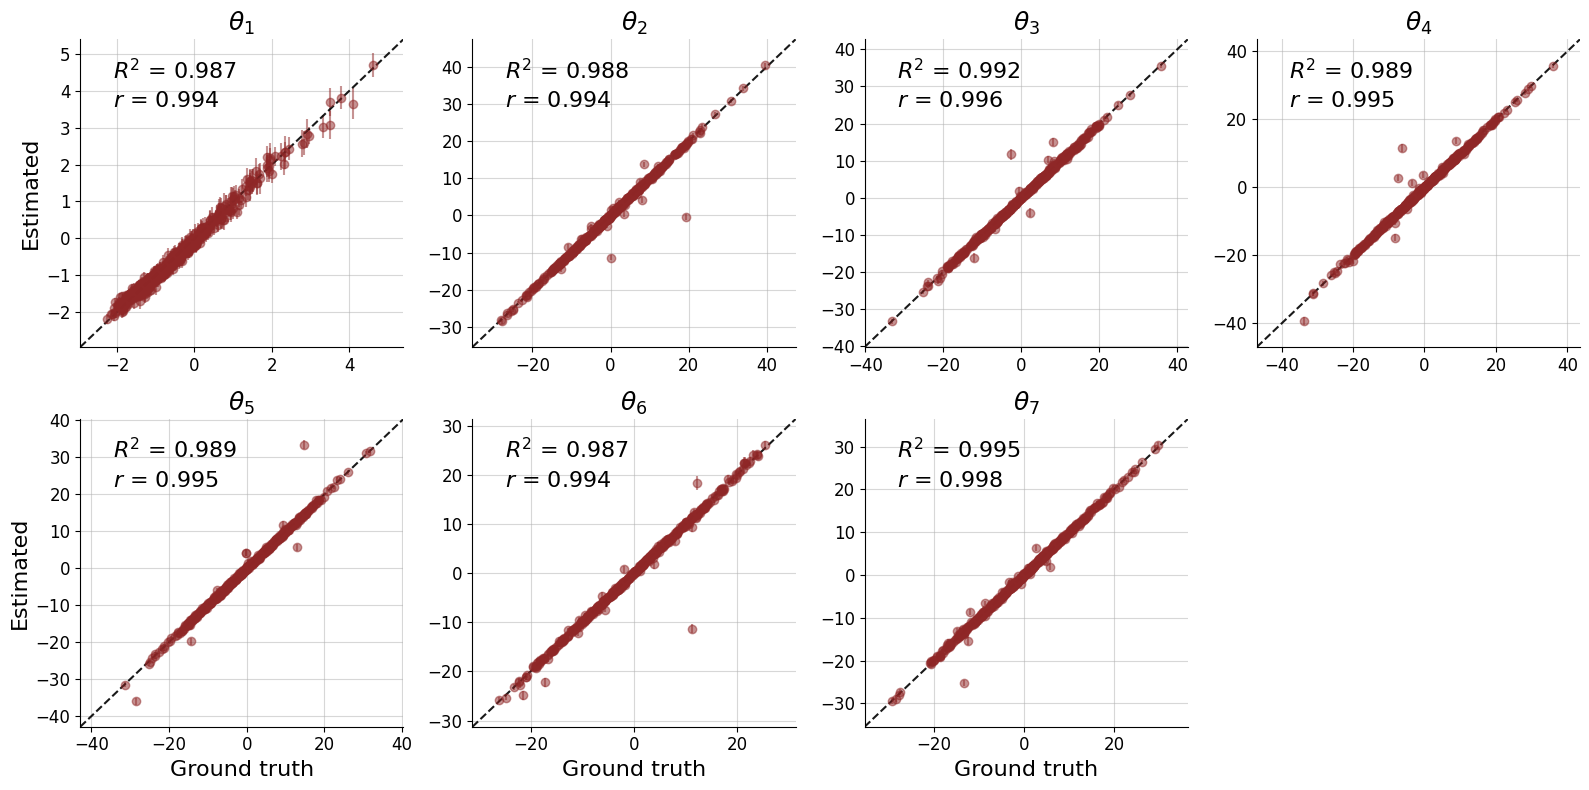

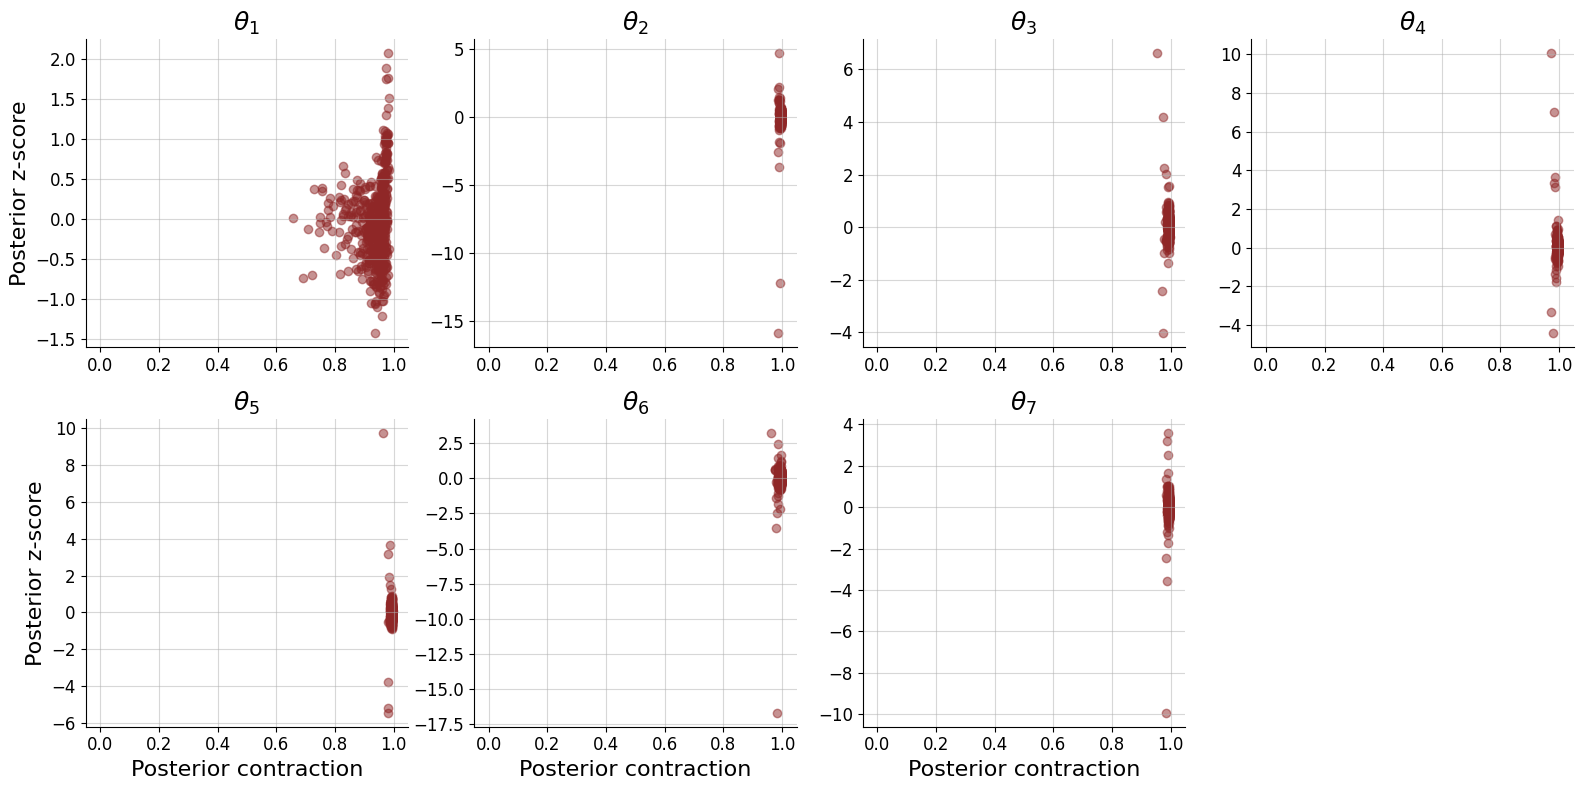

In [1805]:
# Posterior Recovery plot
f = bf.diagnostics.plot_recovery(posterior_draws, normalizing_flow_outputs["parameters"])
plt.savefig('./diagnostic_plots/p_' + str(p) + '/plot_recovery.png')

# z-score contraction: Y axis is the Z-score (want this to be closer to 0), X axis is the contraction (closer to 1 implies consistency)
f = bf.diagnostics.plot_z_score_contraction(posterior_draws, normalizing_flow_outputs["parameters"]) # should be straight lines close to 1
plt.savefig('./diagnostic_plots/p_' + str(p) + '/plot_z_score_contraction.png')
print("finished diagnostics.")

# Simulation Study

In [1806]:
# the simulation study settings
nsims      = 100      # number of simulated datasets
posterior_resolution = 10000

# helper functions
def get_quantiles(x):
    return(np.array([np.quantile(x, .05), np.quantile(x, .50), np.quantile(x, .95)]))

In [1807]:
# GENERATING SIMULATION STUDY DATASETS

# importing the simulation study datasets-- generated from R
sim_study_datasets = np.array(np.loadtxt("../shared_data/p_"+str(p)+"/sim_study_datasets_p"+str(p)+".csv", delimiter=",", dtype=str)[1:,1:], dtype = np.float64)
print(sim_study_datasets.shape) # nsims x nstats

# # creating our own simulation study dataset-- generated from Python
# true_parameters_df = np.tile(true_parameters, reps = (nsims, 1))
# sim_study_datasets = simulator_to_use(true_parameters_df)["sim_data"][:,:,0]
# print(sim_study_datasets.shape) # nsims x nstats

(100, 7)


In [1808]:
parameters_captured = np.zeros_like(true_parameters)
parameter_ADs = np.zeros((nsims, nparams))
posterior_medians = np.zeros((nsims, nparams))
for i in range(nsims): # for each of the 100 datasets...
    # print(i)
    # format the simulation study dataset
    # obs_data = np.log1p(sim_study_dataset[i,:])[np.newaxis, :, np.newaxis].astype(np.float32)
    # obs_data = sim_study_datasets[i,:][np.newaxis, :, np.newaxis].astype(np.float32)
    
    # Obtain posterior draws
    normalizing_flow_inputs = trainer.configurator({"prior_draws": true_parameters[np.newaxis,:], "sim_data":sim_study_datasets[i,:][np.newaxis, :, np.newaxis]})
    post_samples = amortizer.sample(normalizing_flow_inputs, n_samples=posterior_resolution) # draw n_samples from the posterior FOR EACH generated dataset (prior and sim draws)
    
    
    # # Undo standardization to get parameters on their original (unstandardized) scales
    # post_samples = prior_means + post_samples * prior_stds

    # get the posterior quantiles
    median_and_90credible_interval = np.apply_along_axis(get_quantiles, 0, post_samples)

    for j in range(nparams):


        if j == 0:

            # coverage capturing
            if (np.exp(median_and_90credible_interval[0,j]) < np.exp(true_parameters[j]))&(np.exp(true_parameters[j]) < np.exp(median_and_90credible_interval[2,j])):
                parameters_captured[j] = parameters_captured[j] + 1

            # absolute deviation
            parameter_ADs[i,j] = np.abs(np.exp(median_and_90credible_interval[1,j]) - np.exp(true_parameters[j]))

            # save the medians to send to R
            posterior_medians[i,j] = np.exp(median_and_90credible_interval[1,j])

        else: 

            # coverage capturing
            if (median_and_90credible_interval[0,j] < true_parameters[j])&(true_parameters[j] < median_and_90credible_interval[2,j]):
                parameters_captured[j] = parameters_captured[j] + 1

            # absolute deviation
            parameter_ADs[i,j] = np.abs(median_and_90credible_interval[1,j] - true_parameters[j])

            # save the medians to send to R
            posterior_medians[i,j] = median_and_90credible_interval[1,j]

# final averaging calculations:
parameter_coverage = parameters_captured/nsims
parameter_MAD = np.apply_along_axis(np.mean, 0, parameter_ADs)
print("parameter_coverage")
print(parameter_coverage)
print("parameter_MAD")
print(parameter_MAD)

parameter_coverage
[1. 1. 1. 1. 1. 1. 1.]
parameter_MAD
[0.11329283 0.24012107 0.21168866 0.34042914 0.20840127 0.27600302
 0.199591  ]


In [1810]:
np.savetxt("./results/bayesflow_parameter_coverage_p" +str(p) +".csv", parameter_coverage, delimiter=",")


In [1811]:
np.savetxt("./results/bayesflow_parameter_MAD_p" +str(p) +".csv", parameter_MAD, delimiter=",")


In [1812]:
np.savetxt("./results/bayesflow_posterior_medians_p" +str(p) +".csv", posterior_medians, delimiter=",")